# Knowledge Destillation - FitNet: Hints for Thin Deep Nets



This notebook is heavily based on Keras's [knowledge distillation example](https://keras.io/examples/vision/knowledge_distillation/) and on Romero et al., 2014:

```
@article{romero2014fitnets,
  title={Fitnets: Hints for thin deep nets},
  author={Romero, Adriana and Ballas, Nicolas and Kahou, Samira Ebrahimi and Chassang, Antoine and Gatta, Carlo and Bengio, Yoshua},
  journal={arXiv preprint arXiv:1412.6550},
  year={2014}
}
```

In [ ]:
#@title

! pip -qq install -U tensorflow_addons

import tensorflow as tf

gpus = list(tf.config.list_physical_devices('GPU'))

for d in gpus:
  print(d)
  print(f'  Setting device {d} to memory-growth mode.')
  
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
  Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.
Mounted at /content/drive


In [ ]:
import tensorflow as tf

DATA_SOURCE = '/content/drive/Shareddrives/datasets/voc-2012.tar.gz'
LOGS = '/content/drive/Shareddrives/lerdl/logs/pascal-2012'

class Config:
  class data:
    size = (512, 512)
    shape = (*size, 3)
    batch_size = 12
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 120391
    shuffle = True
    classes = 20

    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value((x+1)*127.5, 0, 255), tf.uint8)
    source = DATA_SOURCE

  class aug:
    brightness_delta =  .2
    saturation_lower =  .2
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0
    
  class teacher:
    backbone = tf.keras.applications.ResNet101V2
    weights = f'{LOGS}/resnet101-ce-fine-tune/weights.h5'
    fine_tune_layers = .6
    freeze_batch_norm = False
    dropout_rate = 0.5
  
  class training:
    epochs = 120
    lr_first_decay_steps = 50
    dropout_rate = 0.5
    
    early_reduce_lr_patience = 8
    early_stopping_patience = 30
  
    baseline_logs = f'{LOGS}/kd/resnet50-baseline'
    vanilla_student_logs = f'{LOGS}/kd/resnet50-vanilla-student'
    hint_student_logs = f'{LOGS}/kd/resnet50-hint-student'

  class experiment:
    seed = 11963
    override = True

In [ ]:
input_tensor = tf.keras.Input(Config.data.shape, name='images')

student_backbone = tf.keras.applications.ResNet50V2(
  input_tensor=input_tensor,
  include_top=False,
  weights=None,
)

teacher_backbone = Config.teacher.backbone(
  input_tensor=input_tensor,
  include_top=False
)

teacher_backbone.trainable = False

171327488/171317808 [==============================] - 2s 0us/step


## Setup

In [ ]:
import os
import shutil
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [ ]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [ ]:
from typing import List, Optional
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense

def build_classifier(backbone, dropout_rate=None, name=None):
  y = backbone(input_tensor)
  y = GlobalAveragePooling2D(name='avg_pool')(y)
  y = Dropout(rate=dropout_rate, name='top_dropout')(y)
  y = Dense(Config.data.classes, name='predictions')(y)

  return tf.keras.Model(
    inputs=input_tensor,
    outputs=y,
    name=name)


def unfreeze_top_layers(
    model: tf.keras.Model,
    layers: float,
    freeze_bn: bool
):
  if not layers:
    model.trainable = False
    return

  model.trainable = True

  frozen_layer_ix = int((1-layers) * len(model.layers))
  for ix, l in enumerate(model.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not freeze_bn))
  
  print(f'Unfreezing {layers:.0%} layers. Bottom-most is the {frozen_layer_ix}-nth layer ({model.layers[frozen_layer_ix].name}).')


def train_fn(
    nn: tf.keras.Model,
    train: tf.data.Dataset,
    valid: tf.data.Dataset,
    epochs: int,
    logs: str,
    weights: str,
    initial_epoch:int = 0,
    override: bool = False,
    callbacks: Optional[List[tf.keras.callbacks.Callback]] = None,
):
  try:
    if os.path.exists(logs) and initial_epoch == 0:
      if not override:
        raise ValueError(f'A training was found in {logs}. Either move it or set experiment.override to True.')

      print(f'Overriding previous training at {logs}.')
      shutil.rmtree(logs)
    
    os.makedirs(os.path.dirname(weights), exist_ok=True)

    nn.fit(
      train,
      validation_data=valid,
      epochs=epochs,
      initial_epoch=initial_epoch,
      callbacks=callbacks);

  except KeyboardInterrupt: print('\ninterrupted')
  else: print('\ndone')

In [ ]:
class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

## Dataset

### Augmentation Policy

In [ ]:
def default_policy_fn(image):
  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  # mask = tf.image.stateless_random_flip_left_right(mask, seed=seeds[:, 0])
  
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  # mask = tf.image.stateless_random_flip_up_down(mask, seed=seeds[:, 1])

  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

### Preparing and Performance Settings

In [ ]:
(train_dataset, val_dataset, test_dataset), info = tfds.load(
  'voc/2012',
  split=('train', 'validation', 'test'),
  with_info=True,
  shuffle_files=False,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2012/4.0.0.incompleteBV0L8M/voc-test.tfrecord


  0%|          | 0/10991 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2012/4.0.0.incompleteBV0L8M/voc-train.tfrecord


  0%|          | 0/5717 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2012/4.0.0.incompleteBV0L8M/voc-validation.tfrecord


  0%|          | 0/5823 [00:00<?, ? examples/s]

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2012/4.0.0. Subsequent calls will reuse this data.


In [ ]:
CLASSES = np.asarray(info.features['objects']['label']._int2str)
int2str = info.features['objects']['label'].int2str

In [ ]:
from functools import partial


@tf.function
def load_fn(d, augment=False, named=False):
  image = d['image']
  labels = d['objects']['label']

  image = tf.cast(image, tf.float32)
  
  image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  if named:
    return d['image/filename'], image, labels_to_one_hot(labels)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False, named=False, drop_remainder=True):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (
           ds.map(partial(load_fn, augment=augment, named=named), num_parallel_calls=tf.data.AUTOTUNE)
             .batch(batch_size, drop_remainder=drop_remainder)
             .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
train = prepare(train_dataset, Config.data.batch_size, shuffle=True, augment=True)
valid = prepare(val_dataset, Config.data.batch_size)
test = prepare(test_dataset, Config.data.batch_size, named=True, drop_remainder=False)

### Examples in The Dataset

In [ ]:
#@title

def talk_about(dataset, batches, tag):
  print(tag)
  print(f'  {batches}')
  print(f'  samples: {len(dataset)}')
  print(f'  steps  : {len(batches)}')
  print()


talk_about(train_dataset, train, 'Training')
talk_about(val_dataset, valid, 'Validation')
talk_about(test_dataset, test, 'Testing')

Training
  <PrefetchDataset shapes: ((12, 512, 512, 3), (12, 20)), types: (tf.float32, tf.float32)>
  samples: 5717
  steps  : 476

Validation
  <PrefetchDataset shapes: ((12, 512, 512, 3), (12, 20)), types: (tf.float32, tf.float32)>
  samples: 5823
  steps  : 485

Testing
  <PrefetchDataset shapes: ((None,), (None, 512, 512, 3), (None, 20)), types: (tf.string, tf.float32, tf.float32)>
  samples: 10991
  steps  : 916



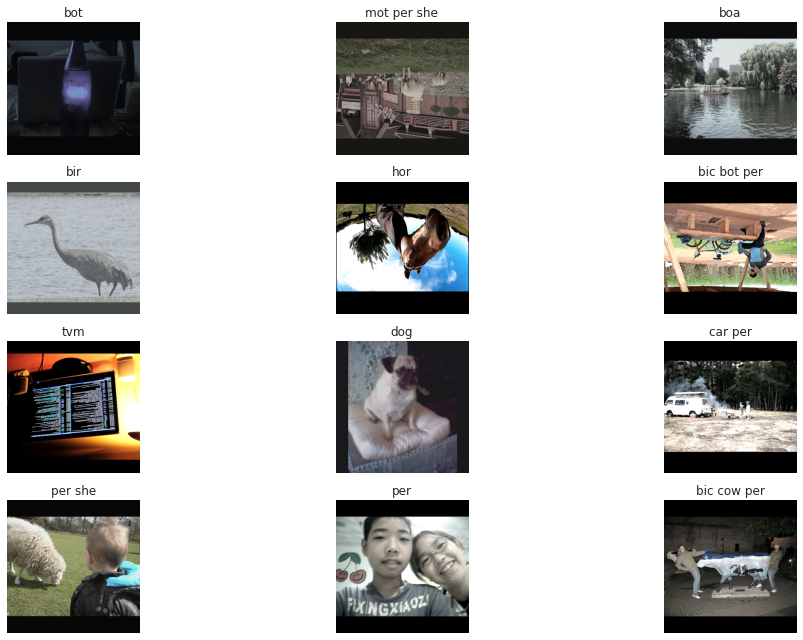

In [ ]:
#@title

for images, labels in train.take(1):
  gt = [' '.join((e[:3] for e in CLASSES[l].astype(str)))
        for l in labels.numpy().astype(bool)]

  visualize(
    Config.data.deprocess(images[:32]),
    gt,
    rows=4,
    figsize=(16, 9)
  )

  plt.savefig('train-examples.jpg')

## Hint-Based Knowledge Distillation

In [ ]:
hints = [
  # dict(name='hint_1',
  #      teacher='conv2_block1_preact_relu',   # (128, 128, 64)
  #      student='conv2_block1_preact_relu'),  # (128, 128, 64)
  # dict(name='hint_2',
  #      teacher='conv2_block2_out',   # (128, 128, 256)
  #      student='conv2_block2_out'),  # (128, 128, 256)
  dict(name='hint_3',
       teacher='conv3_block3_out',   # (64, 64, 512)
       student='conv3_block3_out'),  # (64, 64, 512)
  dict(name='hint_4',
       teacher='conv4_block22_out',  # (32, 32, 1024)
       student='conv4_block5_out'),  # (32, 32, 1024)
  dict(name='hint_5',
       teacher='conv5_block3_out',   # (16, 16, 2048)
       student='conv5_block3_out'),  # (16, 16, 2048)
]

In [ ]:
teacher = build_classifier(
  teacher_backbone,
  dropout_rate=Config.teacher.dropout_rate,
  name='resnet101_teacher_voc12')

unfreeze_top_layers(
  teacher_backbone,
  Config.teacher.fine_tune_layers,
  Config.teacher.freeze_batch_norm
)

teacher.load_weights(Config.teacher.weights)

teacher.trainable = False

Unfreezing 60% layers. Bottom-most is the 150-nth layer (conv4_block6_2_relu).


In [ ]:
student = build_classifier(
  student_backbone,
  dropout_rate=Config.training.dropout_rate,
  name='resnet50_student_voc12')

teacher_signals = [teacher.get_layer('resnet101v2').get_layer(h['teacher']).output
                  for h in hints]

student_signals = [student.get_layer('resnet50v2').get_layer(h['student']).output
                  for h in hints]

teacher_fb = tf.keras.Model(
  teacher.inputs,
  teacher.outputs + teacher_signals,
  name='teacher_fb'
)

student_fb = tf.keras.Model(
  student.inputs,
  student.outputs + student_signals,
  name='student_fb'
)

In [ ]:
def hint_loss(teacher, student):
  return tf.reduce_mean(tf.square(teacher - student))


class Distiller(tf.keras.Model):
  def __init__(
      self,
      student,
      teacher,
      alpha=0.1,
      beta=1.0,
      temperature=3,
      distillation_loss=None,
      **kwargs
  ):
    super().__init__(**kwargs)
    self.student = student
    self.teacher = teacher

    self.alpha = alpha
    self.beta = beta
    self.temperature = temperature

    for i, h in enumerate(hints):
      setattr(self, f'hint_{i}', h)

    self.distillation_loss = distillation_loss or tf.keras.losses.KLDivergence()
  
  def get_config(self):
    config = super().get_config()
    config.update(dict(
      alpha=self.alpha,
      beta=self.beta,
      temperature=self.temperature))

    return config
  
  @tf.function
  def call(self, inputs):
    return self.student(inputs)[0]
  
  def train_step(self, data):
    if len(data) == 3:
      x, y, sample_weight = data
    else:
      sample_weight = None
      x, y = data
    
    tp, *t_signals = self.teacher(x, training=False)

    with tf.GradientTape() as tape:
      sp, *s_signals = self.student(x, training=True)

      features_loss = tf.add_n([hint_loss(tf.stop_gradient(t), s) for t, s in zip(t_signals, s_signals)])

      distillation_loss = self.distillation_loss(
          tf.nn.softmax(tp / self.temperature, axis=1),
          tf.nn.softmax(sp / self.temperature, axis=1),
      )

      student_loss = self.compiled_loss(y, sp, sample_weight=sample_weight)

      loss = (self.alpha * student_loss
              + (1 - self.alpha) * distillation_loss
              + self.beta * features_loss)

    self.optimizer.minimize(loss, self.student.trainable_variables, tape=tape)
    self.compiled_metrics.update_state(y, sp)

    results = {m.name: m.result() for m in self.metrics}
    results.update({
      "student_loss": student_loss,
      "distillation_loss": distillation_loss,
      'features_loss': features_loss
    })

    return results

  def test_step(self, data):
    x, y = data
    sp, *s_signals = self.student(x, training=False)
    student_loss = self.compiled_loss(y, sp, regularization_losses=self.losses)
    self.compiled_metrics.update_state(y, sp)

    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})

    return results

In [ ]:
lecture = Distiller(
  student_fb,
  teacher_fb,
  alpha=0.1,
  beta=1.0,
  temperature=10,
  name='distiller_voc12'
)

lecture.build((None, *Config.data.shape))

lecture.compile(
  optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
  loss=tf.losses.BinaryCrossentropy(from_logits=True),
  metrics=[
    F1Score(num_classes=len(CLASSES), from_logits=True, average='macro', name='f1_score'),
    Precision(from_logits=True, name='precision'),
    Recall(from_logits=True, name='recall'),
    tf.keras.metrics.AUC(multi_label=True, from_logits=True, name='auc'),
  ]
)

### Training

In [ ]:
logs = Config.training.hint_student_logs
weights = f'{Config.training.hint_student_logs}/checkpoint'

train_fn(
  lecture,
  train,
  valid,
  epochs=Config.training.epochs,
  logs=logs,
  weights=weights,
  callbacks=[
    callbacks.TerminateOnNaN(),
    callbacks.ModelCheckpoint(weights, save_best_only=True, save_weights_only=True, verbose=1),
    callbacks.TensorBoard(logs, profile_batch=False),
    callbacks.EarlyStopping(patience=Config.training.early_stopping_patience, verbose=1),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=Config.training.early_reduce_lr_patience, min_lr=0.00001, verbose=1),
  ],
  override=Config.experiment.override
)

## Evaluation

In [ ]:
lecture.load_weights(f'{Config.training.hint_student_logs}/checkpoint')

In [ ]:
classification_threshold = 0.5

In [ ]:
#@title

from sklearn import metrics as skmetrics

def labels_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for ix, (images, labels) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)

    print('.', end='' if (ix+1) % 120 else '\n')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_
  
  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm


l, p = labels_and_probs(lecture, valid)

test_report, test_mcm = metrics_per_label(l, p, threshold=classification_threshold)

t = pd.DataFrame(test_report.mean(axis=0)).T
t['label'] = 'macro avg.'

test_report.append(t)